# Federated learning: Simple experiment with seed

In this notebook we provide a simple example of how to make an experiment of a federated environment with the help of this framework. We are going to use a popular dataset to start the experimentation in a federated environment. The framework provides some functions to load the [Emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset) Digits dataset.

This notebook is a copy of [Basic Concept](./basic_concepts.ipynb) notebook. The difference is that here we set a seed using [Reproducibility](../shfl/private/reproducibility.py) Singleton Class in order to ensure de reproducibility of the experiment. If you execute this experiment many times, you should obtain the same results.

In [1]:
from shfl.private.reproducibility import Reproducibility

# Server
Reproducibility(1234)

# In case of client
# Reproducibility.getInstance().set_seed(ID)

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import shfl

database = shfl.data_base.Emnist()
train_data, train_labels, val_data, val_labels, test_data, test_labels = database.load_data()

Let's inspect some properties of the loaded data.

In [3]:
print(len(train_data))
print(len(val_data))
print(len(test_data))
print(type(train_data[0]))
train_data[0].shape

200000
40000
40000
<class 'numpy.ndarray'>


(28, 28)

So, as we have seen, our dataset is composed of a set of matrices of 28 by 28. Before starting with the federated scenario, we can take a look to a sample in the training data.

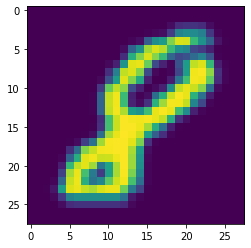

In [4]:
plt.imshow(train_data[0])

We are going to simulate a federated learning scenario with a set of client nodes containing private data, and a central server that will be responsible to coordinate the different clients. But, first of all, we have to simulate the data contained in every client. In order to do that, we are going to use the previously loaded dataset. The assumption in this example will be the data is distributed as a set of independent and identically distributed random variables, having every node approximately the same amount of data. There are a set of different possibilities in order to distribute the data. The distribution of the data is one of the factors that could impact more a federated algorithm. Therefore, the framework contains the implementation of some of the most common distributions that allow you to experiment different situations easily. In [Federated Sampling](./federated_sampling.ipynb) you can dig into the options that the framework provides at the moment.

In [5]:
iid_distribution = shfl.data_distribution.IidDataDistribution(database)
federated_data, test_data, test_labels = iid_distribution.get_federated_data(num_nodes=20, percent=10)

That's it! We have created federated data from the Emnist dataset using 20 nodes and 10 percent of the available data. This data is distributed to a set of data nodes in the form of private data. Let's learn a little more about the federated data.

In [6]:
print(type(federated_data))
print(federated_data.num_nodes())
federated_data[0].private_data

<class 'shfl.private.federated_operation.FederatedData'>
20
Node private data, you can see the data for debug purposes but the data remains in the node
<class 'dict'>
{'139944360039568': <shfl.private.data.LabeledData object at 0x7f4755d72950>}


As we can see, private data in a node is not accesible directly but the framework provides mechanisms to use this data in a machine learning model. A federated learning algorithm is defined by a machine learning model locally deployed in each node that learns from the respective node’s private data and an aggregating mechanism to aggregate the different model parameters uploaded by the client nodes to a central node. In this example we will use a deep learning model using keras to build it. The framework provides classes to allow using Tensorflow (see [Basic Concepts Tensorflow](./basic_concepts_tensorflow.ipynb)) and Keras models into a federated learning scenario, your job is only to create a function acting as model builder. Moreover, the framework provides classes to allow using pretrained Tensorflow and Keras models (see [Basic Concepts Pretrained Models](./basic_concepts_pretrained.ipynb)). In this example build a Keras learning model.  

In [7]:
import keras

def model_builder():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1, input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', strides=1))
    model.add(keras.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    
    return shfl.model.DeepLearningModel(model)

Now, the only piece missing is the aggregation operator. Nevertheless, the framework provides some aggregation operators that we can use. In the following piece of code we define the federated aggregation mechanism. Moreover, we define de federated goverment based on the keras learning model, the federated data and the aggregation mechanism.

In [8]:
aggregator = shfl.federated_aggregator.FedAvgAggregator()
federated_government = shfl.learning_approach.FederatedGovernment(model_builder, federated_data, aggregator)

If you want to see all the aggregation operators you can check the following notebook [Federated Aggregation Operators](./aggregation_operators.ipynb). Before running the algorithm, we want to apply a transformation to the data. The good practise to do that is to define a federated operation that will ensure that the transformation is applied to the federated data in all the client nodes. We want to reshape the data, so we define the following FederatedTransformation.

In [9]:
import numpy as np

class Reshape(shfl.private.FederatedTransformation):
    
    def apply(self, labeled_data):
        labeled_data.data = np.reshape(labeled_data.data, (labeled_data.data.shape[0], labeled_data.data.shape[1], labeled_data.data.shape[2],1))
        
shfl.private.federated_operation.apply_federated_transformation(federated_data, Reshape())

In addition, we want to normalize the data. We define a federated transformation using mean and standard deviation (std) parameters. We use mean and std estimated from the training set in this example. Although the ideal parameters would be an aggregation of the mean and std of each client's training datasets, we use the mean and std of the global dataset as a simple approximation.

In [10]:
import numpy as np

class Normalize(shfl.private.FederatedTransformation):
    
    def __init__(self, mean, std):
        self.__mean = mean
        self.__std = std
    
    def apply(self, labeled_data):
        labeled_data.data = (labeled_data.data - self.__mean)/self.__std
        
        
mean = np.mean(train_data.data)
std = np.std(train_data.data)
shfl.private.federated_operation.apply_federated_transformation(federated_data, Normalize(mean, std))

We are now ready to execute our federated learning algorithm.

In [11]:
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], test_data.shape[2],1))
federated_government.run_rounds(3, test_data, test_labels)

Accuracy round 0
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d27590>: [25.62013853740692, 0.7350999712944031]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d72a90>: [25.226747469520568, 0.6887249946594238]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d72210>: [32.713278083992, 0.6582249999046326]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d7bb50>: [29.18368230304718, 0.6477500200271606]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d7b9d0>: [44.05608992080688, 0.5671749711036682]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d337d0>: [48.94080881652832, 0.5511500239372253]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d33c10>: [22.350650508308412, 0.

Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d88ad0>: [42.98323505706787, 0.7193250060081482]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d886d0>: [53.08043603744507, 0.6759499907493591]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d88750>: [28.76791482043266, 0.7645249962806702]
Test performance client <shfl.private.federated_operation.FederatedDataNode object at 0x7f4755d3bc90>: [27.481977243623138, 0.779325008392334]
Global model test performance : [27.214288069947774, 0.795324981212616]



